In [11]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import eig, inv
import statsmodels.api as sm

### `factor_an_static.R`

In [10]:
def varimax(Phi, gamma=1.0, q=20, tol=1e-6):
    p, k = Phi.shape
    R = np.eye(k)
    d = 0
    for i in range(q):
        d_old = d
        Lambda = Phi @ R
        u, s, vh = np.linalg.svd(Phi.T @ (Lambda**3 - (gamma/p) * Lambda @ np.diag(np.sum(Lambda**2, axis=0))))
        R = u @ vh
        d = np.sum(s)
        if d_old != 0 and d/d_old < 1 + tol:
            break
    return Phi @ R, R

def factor_an_static(X):
    # X: n x p
    n1 = X.shape()[0] if callable(getattr(X, "shape", None)) else X.shape[0]
    n1 = X.shape[0]
    m = np.mean(X, axis=0)

    Rho = np.corrcoef(X, rowvar=False)

    std = np.tile(np.sqrt(np.var(X, axis=0, ddof=0)), (n1, 1))
    zz = (X - m) / std
    Cor = np.corrcoef(zz, rowvar=False)

    ev_vals, ev_vecs = eig(Cor)
    eigval = ev_vals.real
    eigvec = ev_vecs.real

    idx = np.argsort(eigval)[::-1]
    eigval = eigval[idx]
    eigvec = eigvec[:, idx]
    Q = eigvec[:, :3] * np.sqrt(eigval[:3])

    ld_rot, _ = varimax(Q, gamma=1.0, q=200, tol=1e-6)

    loadings = ld_rot.copy()
    loadings[:, 0] = ld_rot[:, 0]
    loadings[:, 1] = -ld_rot[:, 2]
    loadings[:, 2] = ld_rot[:, 1]

    f2 = inv(Rho) @ loadings
    F = zz @ f2
    return {"F": F, "loadings": loadings, "f2": f2, "eigval": eigval, "eigvec": eigvec}


In [4]:
input_folder = "Factors/"
files = sorted([f for f in os.listdir(input_folder) if f.endswith('.csv')])

In [5]:
all_dates = []
for file in files:
    df = pd.read_csv(os.path.join(input_folder, file))
    all_dates.append(pd.to_datetime(df['Date'].iloc[0]))

all_dates = sorted(all_dates)
start_date = pd.to_datetime("2015-03-06")
latest_date = all_dates[-1]

In [14]:
print(file)
df = pd.read_csv(os.path.join(input_folder, file))
print("---\n",df.columns)

2025-02-14 Factors.csv
---
 Index(['Date', 'Asset', 'Type', 'Q_0_005', 'Q_0_01', 'Q_0_025', 'Q_0_05',
       'Q_0_95', 'Q_0_975', 'Q_0_99', 'Q_0_995', 'CTE_0_005', 'CTE_0_01',
       'CTE_0_025', 'CTE_0_05', 'CTE_0_95', 'CTE_0_975', 'CTE_0_99',
       'CTE_0_995', 'FIGARCH_d', 'Stable_alpha', 'Stable_gamma', 'Variance',
       'Skewness', 'Kurtosis', 'ACF_Lag1', 'Hurst'],
      dtype='object')


In [16]:
static_df = pd.read_csv(os.path.join(input_folder, files[0]))
stats_cols = ['Q_0_005','Q_0_01','Q_0_025','Q_0_05','Q_0_95','Q_0_975','Q_0_99','Q_0_995','CTE_0_005','CTE_0_01','CTE_0_025','CTE_0_05','CTE_0_95','CTE_0_975','CTE_0_99','CTE_0_995','FIGARCH_d','Stable_alpha','Stable_gamma','Variance','Skewness','Kurtosis','ACF_Lag1','Hurst']
stats = static_df[stats_cols].copy()
fa = factor_an_static(stats.values)

eigval = fa["eigval"]
eigvec = fa["eigvec"]
loadings = fa["loadings"]
f2 = fa["f2"]

In [25]:
dynamic_list = []
for wave_idx, file in enumerate(files, start=1):
    df_wave = pd.read_csv(os.path.join(input_folder, file))
    df_wave = df_wave.copy()
    df_wave["wave"] = wave_idx
    df_wave["type_assets"] = df_wave["Type"]
    df_wave["symb_assets"] = df_wave["Asset"]
    dynamic_list.append(df_wave)

data_dynamic = pd.concat(dynamic_list, ignore_index=True)
n_waves = len(files)
LR = np.full((n_waves, 7), np.nan)
Date = pd.to_datetime(all_dates)

In [89]:
n_waves

1731

In [ ]:
i = 1000
stats_t = data_dynamic[data_dynamic["wave"] == i].copy()
stats_t[stats_cols] = stats_t[stats_cols].fillna(0.0)

n1 = stats_t.shape[0]
m = stats_t[stats_cols].mean(axis=0).values

Rho = np.corrcoef(stats_t[stats_cols].values, rowvar=False)
Rho = np.nan_to_num(Rho, nan=0.0)

std = np.tile(np.sqrt(np.var(stats_t[stats_cols].values, axis=0, ddof=0)), (n1, 1))
zz = (stats_t[stats_cols].values - np.tile(m, (n1, 1))) / std
zz = np.nan_to_num(zz, nan=0.0)

F_scores = zz @ f2  # n1 x 3

type_assets = stats_t["type_assets"].astype(str)
symb_assets = stats_t["symb_assets"].astype(str)

index_crypto = type_assets.str.contains("Crypto", na=False).astype(int)

DF = pd.DataFrame(F_scores, columns=["X1", "X2", "X3"])
DF["symb_assets"] = symb_assets.values
DF["type_assets"] = type_assets.values
DF["type_crypto"] = index_crypto.values.astype(int)

for k, col in enumerate(["X1", "X2", "X3"], start=1):
    y = DF["type_crypto"].values
    X = sm.add_constant(DF[[col]].values, has_constant="add")
    try:
        res = sm.Logit(y, X).fit(disp=False)
        LR[i - 1, 0] = i
        LR[i - 1, k] = res.llr
        LR[i - 1, k + 3] = res.llr_pvalue
    except Exception:
        LR[i - 1, 0] = i
        LR[i - 1, k] = np.nan
        LR[i - 1, k + 3] = np.nan



1000.0 432.6952312687614 3.7506426415494047 56.454451702451024 4.20993511258283e-96 0.05278721250680724 5.751536227995165e-14


In [75]:
for i in range(1, n_waves + 1):
    stats_t = data_dynamic[data_dynamic["wave"] == i].copy()
    stats_t[stats_cols] = stats_t[stats_cols].fillna(0.0)

    n1 = stats_t.shape[0]
    m = stats_t[stats_cols].mean(axis=0).values

    Rho = np.corrcoef(stats_t[stats_cols].values, rowvar=False)
    Rho = np.nan_to_num(Rho, nan=0.0)

    std = np.tile(np.sqrt(np.var(stats_t[stats_cols].values, axis=0, ddof=0)), (n1, 1))
    zz = (stats_t[stats_cols].values - np.tile(m, (n1, 1))) / std
    zz = np.nan_to_num(zz, nan=0.0)

    F_scores = zz @ f2  # n1 x 3

    type_assets = stats_t["type_assets"].astype(str)
    symb_assets = stats_t["symb_assets"].astype(str)

    index_crypto = type_assets.str.contains("Crypto", na=False).astype(int)

    DF = pd.DataFrame(F_scores, columns=["X1", "X2", "X3"])
    DF["symb_assets"] = symb_assets.values
    DF["type_assets"] = type_assets.values
    DF["type_crypto"] = index_crypto.values.astype(int)

    for k, col in enumerate(["X1", "X2", "X3"], start=1):
        y = DF["type_crypto"].values
        X = sm.add_constant(DF[[col]].values, has_constant="add")
        try:
            res = sm.Logit(y, X).fit(disp=False)
            LR[i - 1, 0] = i
            LR[i - 1, k] = res.llr
            LR[i - 1, k + 3] = res.llr_pvalue
        except Exception:
            LR[i - 1, 0] = i
            LR[i - 1, k] = np.nan
            LR[i - 1, k + 3] = np.nan


In [76]:
LR_df = pd.DataFrame(LR, columns=["X1","X2","X3","X4","X5","X6","X7"])
LR_df["Date"] = Date.values

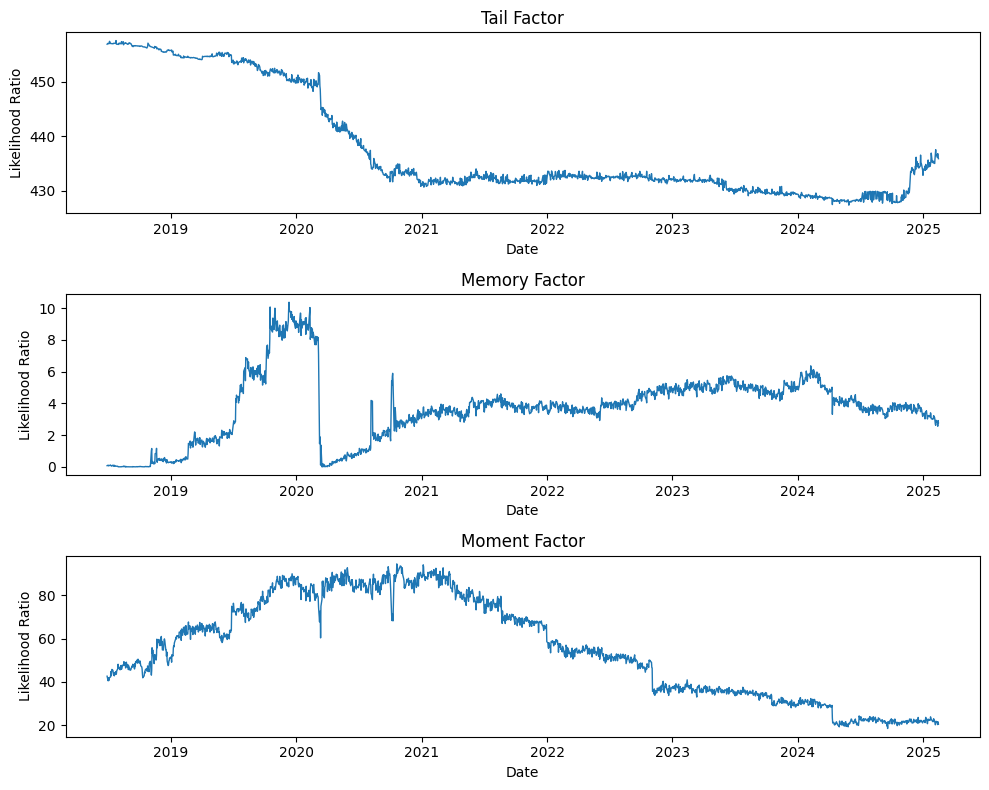

In [79]:
plt.figure(figsize=(10, 8))

# Tail Factor (X2)
plt.subplot(3, 1, 1)
plt.plot(LR_df["Date"], LR_df["X2"], linewidth=1)
plt.xlabel("Date")
plt.ylabel("Likelihood Ratio")
plt.title("Tail Factor")

# Memory Factor (X3)
plt.subplot(3, 1, 2)
plt.plot(LR_df["Date"], LR_df["X3"], linewidth=1)
plt.xlabel("Date")
plt.ylabel("Likelihood Ratio")
plt.title("Memory Factor")

# Moment Factor (X4)
plt.subplot(3, 1, 3)
plt.plot(LR_df["Date"], LR_df["X4"], linewidth=1)
plt.xlabel("Date")
plt.ylabel("Likelihood Ratio")
plt.title("Moment Factor")

plt.tight_layout()
# plt.savefig("LR.png", dpi=150)
plt.show()